# classification model

### import library

In [195]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import*
from sklearn import preprocessing
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
from pickle import dump
from pickle import load
from keras.models import load_model

### Load_data set

In [196]:
#set the path 
%cd /content/drive/My Drive/Self Case Study 1/data/output/FD004

/content/drive/My Drive/Self Case Study 1/data/output/FD004


In [197]:
imp_col = ['RUL','Engine_No','T50','Nf','Ps30','phi','NRf','NRc','BPR','W31','W32','T48','T41','T90','Ve','EGT_margin','Nc/Nf','PCNcRdmd ','M_cold','W_f','Thrust','Fan_thrust','core_thrust','TSFC','Thermal_efficiency']

In [198]:
Train= pd.read_csv('Feature_Engg_Train_F0004.csv', usecols =imp_col) 
Test = pd.read_csv('Feature_Engg_Test_F0004.csv',  usecols =imp_col) 

### Data Preparation

we need to create binary labels for data set. From 0 to 30 cycles, we’ve labeled as 1(fail) and rest (>30) as 0(Not fail) .

In [199]:
period=30 
Train['label'] = Train['RUL'].apply(lambda x: 1 if x <= period else 0) 
Test['label'] =  Test['RUL'].apply(lambda x: 1 if x <= period else 0)  

### standardization

Sklearns’ MinMaxScaler can be used to create a scaler fitted to our train data. The default settings create a scaler to scale our training features between 0–1. The scaler is then applied to both our X_train and X_test set.

In [200]:
min_max= MinMaxScaler()
cols = Train.columns.difference(['RUL','Engine_No','label']) 
norm_train_df = pd.DataFrame(min_max.fit_transform(Train[cols]), columns=cols, index=Train.index)
join_df = Train[Train.columns.difference(cols)].join(norm_train_df)
Train= join_df.reindex(columns = Train.columns) 

In [201]:
# save the scaler
dump(min_max, open('scaler.pkl', 'wb')) 

In [202]:
norm_train_df = pd.DataFrame(min_max.transform(Test[cols]), columns=cols, index=Test.index)
join_df = Test[Test.columns.difference(cols)].join(norm_train_df)
Test= join_df.reindex(columns = Test.columns) 

In [203]:
print('X_train : {}'.format(Train.shape)) 
print('X_test: {}'.format(Test.shape)) 

X_train : (61249, 26)
X_test: (41214, 26)


In [204]:
Train.head()

,Engine_No,T50,Nf,Ps30,phi,NRf,NRc,BPR,W31,W32,RUL,T48,T41,T90,Ve,EGT_margin,Nc/Nf,PCNcRdmd,M_cold,W_f,Thrust,Fan_thrust,core_thrust,TSFC,Thermal_efficiency,label
0,1,0.212586,0.626983,0.458604,0.003593,0.993111,0.550773,0.400540,0.015473,0.015881,320,0.394846,0.378879,0.045750,0.856931,0.954250,0.038740,0.019523,0.007387,0.661786,0.002066,0.001805,0.087721,0.974977,0.033642,0
1,1,0.511781,0.862888,0.641234,0.450364,0.992395,0.481761,0.351346,0.477968,0.481487,319,0.685553,0.673759,0.394943,0.789856,0.605057,0.023058,0.373300,0.811761,0.890320,0.242303,0.237075,0.334262,0.496223,0.409032,0
2,1,0.222481,0.627110,0.456169,0.003202,0.993056,0.531031,0.423787,0.010764,0.018932,318,0.400015,0.383196,0.055580,0.860897,0.944420,0.034251,0.015325,0.010194,0.673950,0.001978,0.001691,0.087869,0.973579,0.034789,0
3,1,0.224835,0.627026,0.457792,0.003641,0.993194,0.553707,0.401716,0.012782,0.018724,317,0.389719,0.373833,0.051895,0.883244,0.948105,0.039622,0.020374,0.007536,0.662433,0.002292,0.001510,0.092148,0.971033,0.037274,0
4,1,0.022025,0.001055,0.035714,0.087492,0.001405,0.048140,0.920536,0.130172,0.145560,316,0.013924,0.018730,0.026968,0.006459,0.973032,0.890973,0.914910,0.160060,0.025999,0.078233,0.096601,0.002038,0.371037,0.445254,0


### Test and cross_validation splite 

Split Test data into cross_validation and test data, we pick the last sequence data points as test data,remaining data points as cross_validation.

In [205]:
def splite_data(sequence_length,data,cross_val=True):
  val_data=[]
  for id in data['Engine_No'].unique():
    if len(data[data['Engine_No']==id])>= sequence_length:
      if cross_val:
        # Remaining data points as cross_validation(other than last sequence data points).
        val_data.append(data[data['Engine_No']==id][:-sequence_length])
      else:
        # We pick the last sequence data points as test data
        val_data.append(Test[Test['Engine_No']==id][-sequence_length:]) 
    else:
      False
  return pd.concat(val_data) 

In [206]:
# cross_val is other than last sequence data points (test data 41214 = cross_val(40966)+test(248))
cross =     splite_data(1,Test,cross_val=True) 

# we have 248 engine data,# We pick the last sequence data points as test data 
Test_data = splite_data(1,Test,cross_val= False) 

print('X_train : {}'.format(Train.shape)) 
print('X_cross_val : {}'.format(cross.shape))  
print('X_test: {}'.format(Test_data.shape)) 

X_train : (61249, 26)
X_cross_val : (40966, 26)
X_test: (248, 26)


In [207]:
y_train =  Train['label'] 
x_train =  Train.drop(['RUL','Engine_No','label'],axis = 1) 
print('X_train : {}'.format(x_train.shape))

y_cross_val =  cross['label'] 
x_cross_val =  cross.drop(['RUL','Engine_No','label'],axis = 1) 
print('X_train : {}'.format(x_cross_val.shape))

y_test =  Test_data['label'].reset_index(drop=True)
x_test =  Test_data.drop(['RUL','Engine_No','label'],axis = 1).reset_index(drop=True)
print('X_train : {}'.format(x_test.shape)) 

X_train : (61249, 23)
X_train : (40966, 23)
X_train : (248, 23)


In [208]:
print(y_train.value_counts())
print(y_cross_val.value_counts())
print(y_test.value_counts())

0    53530
1     7719
Name: label, dtype: int64
0    40155
1      811
Name: label, dtype: int64
0    195
1     53
Name: label, dtype: int64


- we understand that data is highly imbalanced.
- we will try to implement ML models and performance of model.

## Machine learning models

In [209]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column 
    B =(C/C.sum(axis=0))
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### logistic regression

For values of alpha =  1e-07 The log loss is: 0.04352015063135774
For values of alpha =  1e-06 The log loss is: 0.04273198141877408
For values of alpha =  1e-05 The log loss is: 0.050404818764655586
For values of alpha =  0.0001 The log loss is: 0.07359401489729601
For values of alpha =  0.001 The log loss is: 0.10334460624781937
For values of alpha =  0.01 The log loss is: 0.14548275541501618
For values of alpha =  0.1 The log loss is: 0.16511780489125366
For values of alpha =  1 The log loss is: 0.17296999156848072


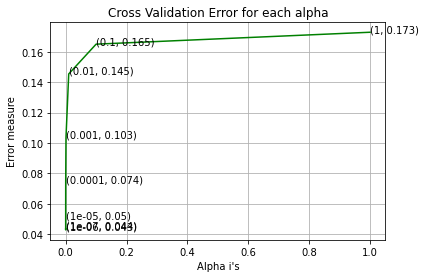

For values of best alpha =  1e-06 The train log loss is: 0.1110712931020091
For values of best alpha =  1e-06 The cross validation log loss is: 0.04273198141877408
For values of best alpha =  1e-06 The test log loss is: 0.19344683265525134


In [210]:
alpha = [10 ** x for x in range(-7, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) 
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cross_val)
    cv_log_error_array.append(log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots() 
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train) 
###############
# save the model to disk
filename = "logistic_model.pkl"
pickle.dump(clf, open(filename, 'wb'))
###################################
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)
###################################
# save the model to disk
filename = "logistic_model_cali.pkl"
pickle.dump(sig_clf, open(filename, 'wb')) 

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cross_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [211]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y) 
    pred_y = sig_clf.predict(test_x) 

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x))) 

    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", (np.count_nonzero((pred_y- test_y))/test_y.shape[0])*100)

    precision, recall, fscore, support = score(test_y, pred_y) 
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print("-"*50)
    plot_confusion_matrix(test_y, pred_y) 

#### Confusion matrix

**Cross Validation**

Log loss : 0.04203695434271862
Number of mis-classified points : 1.6501489039691453
precision: [0.98895247 0.61344538]
recall: [0.9942722  0.45006165]
fscore: [0.9916052  0.51920341]
support: [40155   811]
--------------------------------------------------
-------------------- Confusion matrix --------------------


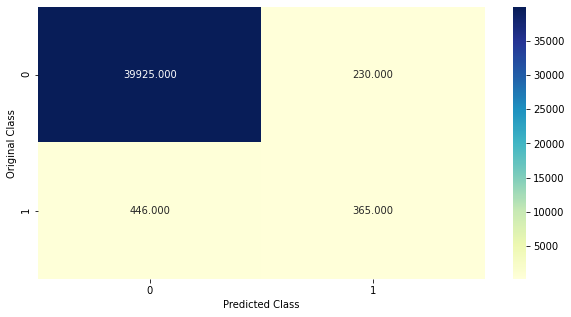

-------------------- Precision matrix (Columm Sum=1) --------------------


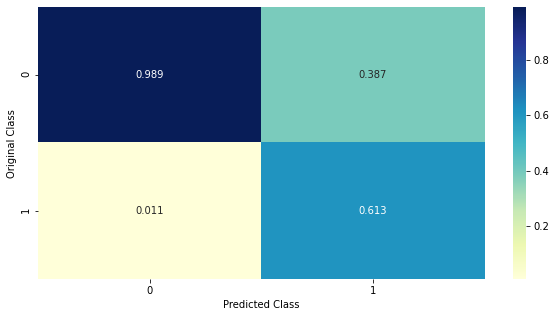

-------------------- Recall matrix (Row sum=1) --------------------


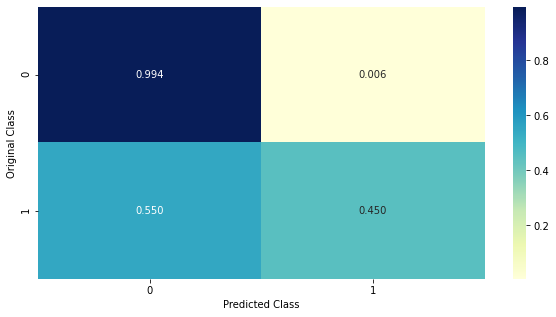

In [212]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(x_train, y_train, x_cross_val, y_cross_val, clf) 

**Test data**

Log loss : 0.19295058854701982
Number of mis-classified points : 8.064516129032258
precision: [0.91866029 0.92307692]
recall: [0.98461538 0.67924528]
fscore: [0.95049505 0.7826087 ]
support: [195  53]
--------------------------------------------------
-------------------- Confusion matrix --------------------


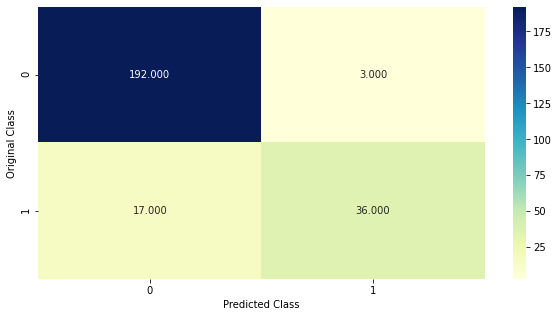

-------------------- Precision matrix (Columm Sum=1) --------------------


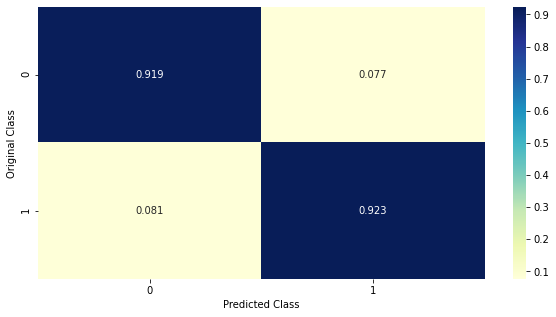

-------------------- Recall matrix (Row sum=1) --------------------


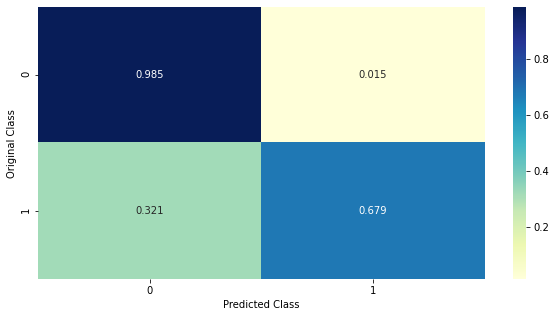

In [213]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(x_train, y_train, x_test, y_test, clf) 

### Linear SVM

For values of alpha =  1e-07 The log loss is: 0.04243707743208086
For values of alpha =  1e-06 The log loss is: 0.04235332640011426
For values of alpha =  1e-05 The log loss is: 0.04412163773274942
For values of alpha =  0.0001 The log loss is: 0.05585499302408436
For values of alpha =  0.001 The log loss is: 0.07867366785073775
For values of alpha =  0.01 The log loss is: 0.14049300447375543
For values of alpha =  0.1 The log loss is: 0.16492586775006343
For values of alpha =  1 The log loss is: 0.16666456927958986
For values of alpha =  10 The log loss is: 0.16666906592683509
For values of alpha =  100 The log loss is: 0.16666906619477492


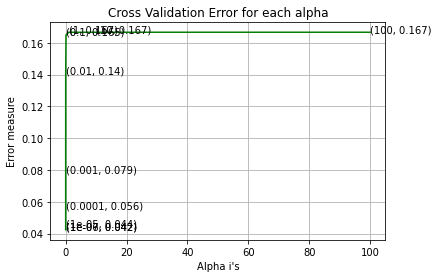

For values of best alpha =  1e-06 The train log loss is: 0.1110712931020091
For values of best alpha =  1e-06 The cross validation log loss is: 0.04273198141877408
For values of best alpha =  1e-06 The test log loss is: 0.19344683265525134


In [214]:
alpha = [10 ** x for x in range(-7,3)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', class_weight='balanced', random_state=42) 
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cross_val)
    cv_log_error_array.append(log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train) 

###################################
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)
##################################
# save the model to disk
filename = "linear_svm_model_cali.pkl"
pickle.dump(sig_clf, open(filename, 'wb')) 

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cross_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Confusion matrix

**Cross Validation**

Log loss : 0.04235332640011426
Number of mis-classified points : 1.6379436605965925
precision: [0.9890992  0.61627907]
recall: [0.99424729 0.45745993]
fscore: [0.99166656 0.52512385]
support: [40155   811]
--------------------------------------------------
-------------------- Confusion matrix --------------------


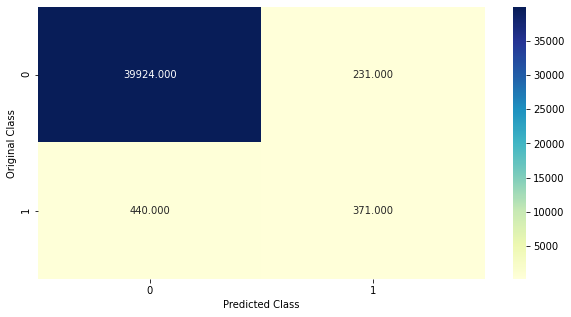

-------------------- Precision matrix (Columm Sum=1) --------------------


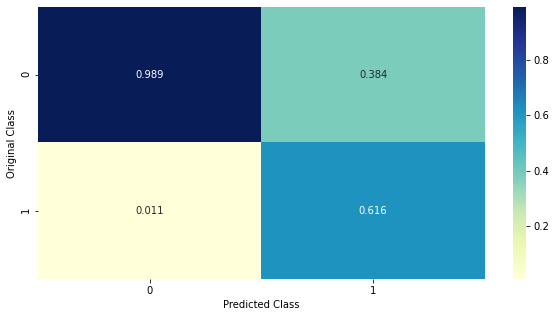

-------------------- Recall matrix (Row sum=1) --------------------


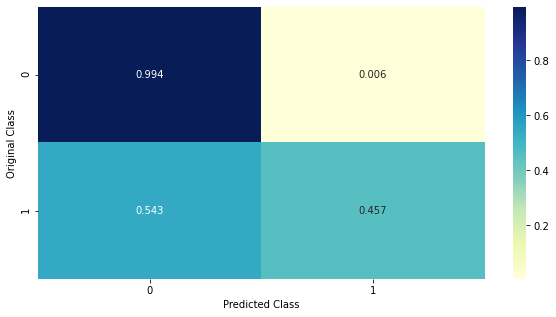

In [215]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(x_train, y_train, x_cross_val, y_cross_val,clf) 

**Test data**

Log loss : 0.19504662127738778
Number of mis-classified points : 8.870967741935484
precision: [0.9138756 0.8974359]
recall: [0.97948718 0.66037736]
fscore: [0.94554455 0.76086957]
support: [195  53]
--------------------------------------------------
-------------------- Confusion matrix --------------------


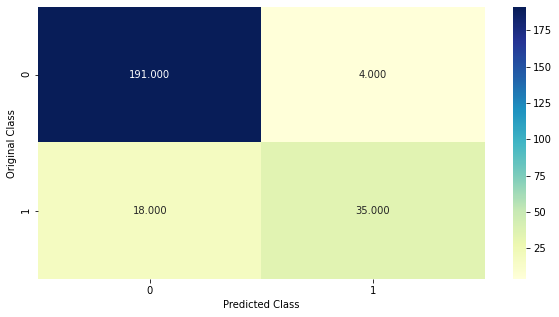

-------------------- Precision matrix (Columm Sum=1) --------------------


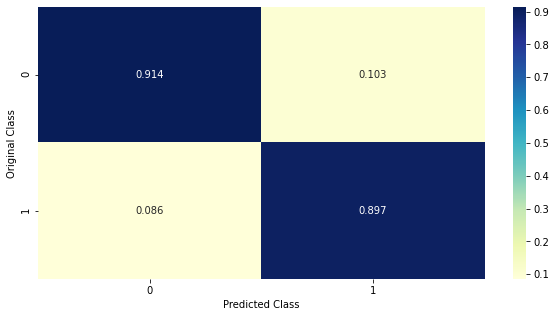

-------------------- Recall matrix (Row sum=1) --------------------


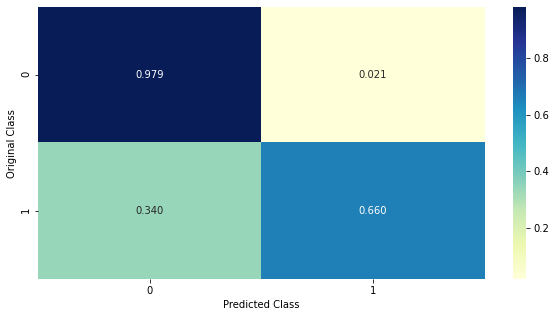

In [216]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(x_train, y_train, x_test, y_test, clf) 

### Random Forest Classifier

In [217]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(x_train,y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train,y_train)
        sig_clf_probs = sig_clf.predict_proba(x_cross_val)
        cv_log_error_array.append(log_loss(y_cross_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cross_val, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(x_train,y_train)
###################################
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train,y_train) 
###################################
# save the model to disk
filename = "RF_model_cali.pkl"
pickle.dump(sig_clf, open(filename, 'wb')) 

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cross_val)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cross_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 0.09478770159871461
for n_estimators = 10 and max depth =  3
Log Loss : 0.08635548479399495
for n_estimators = 10 and max depth =  5
Log Loss : 0.06598898401594852
for n_estimators = 10 and max depth =  10
Log Loss : 0.05224586549903772
for n_estimators = 50 and max depth =  2
Log Loss : 0.09991755719757461
for n_estimators = 50 and max depth =  3
Log Loss : 0.0833705585939557
for n_estimators = 50 and max depth =  5
Log Loss : 0.06594402303545975
for n_estimators = 50 and max depth =  10
Log Loss : 0.051754363801157284
for n_estimators = 100 and max depth =  2
Log Loss : 0.09633357100548957
for n_estimators = 100 and max depth =  3
Log Loss : 0.08307585260566165
for n_estimators = 100 and max depth =  5
Log Loss : 0.06544693395427255
for n_estimators = 100 and max depth =  10
Log Loss : 0.05167429666989027
for n_estimators = 200 and max depth =  2
Log Loss : 0.09775307209805612
for n_estimators = 200 and max depth =  3
Log Loss : 0.0

#### Confusion matrix

**cross validation**

Log loss : 0.05146535264567987
Number of mis-classified points : 1.4280134745886832
precision: [0.98994602 0.69349315]
recall: [0.99554227 0.49938348]
fscore: [0.99273626 0.58064516]
support: [40155   811]
--------------------------------------------------
-------------------- Confusion matrix --------------------


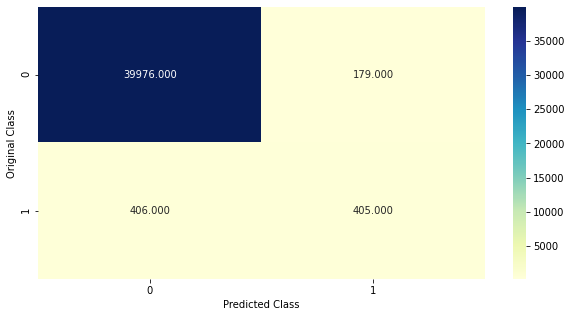

-------------------- Precision matrix (Columm Sum=1) --------------------


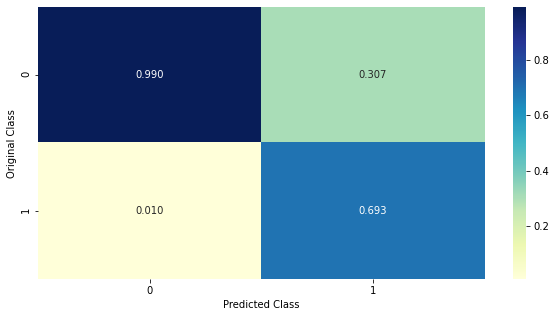

-------------------- Recall matrix (Row sum=1) --------------------


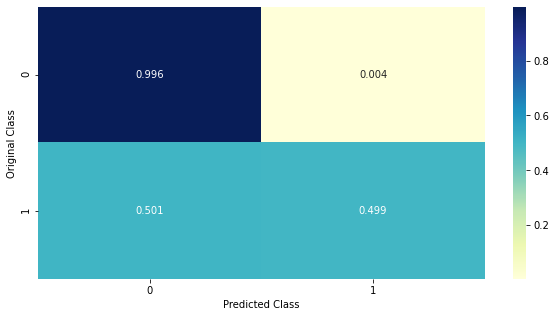

In [218]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(x_train,y_train,x_cross_val,y_cross_val, clf)

**Test data**

Log loss : 0.17794967565283137
Number of mis-classified points : 6.451612903225806
precision: [0.94527363 0.89361702]
recall: [0.97435897 0.79245283]
fscore: [0.95959596 0.84      ]
support: [195  53]
--------------------------------------------------
-------------------- Confusion matrix --------------------


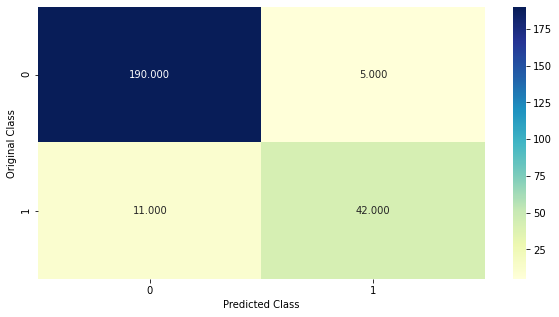

-------------------- Precision matrix (Columm Sum=1) --------------------


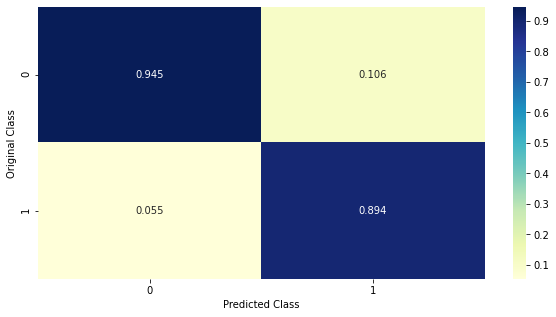

-------------------- Recall matrix (Row sum=1) --------------------


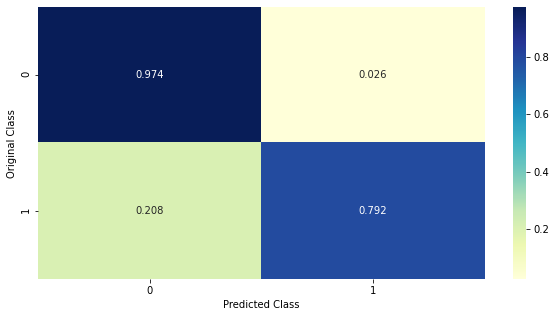

In [219]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(x_train,y_train,x_test,y_test, clf) 

## Deep learning models

#### Data preprocessing

In [151]:
x_train= Train 
# cross_val is other than last sequence data points (test data 13096 = cross_val(10096)+test(300))
x_cross = splite_data(50,Test,cross_val=True) 

# we have 248 engine data,# We pick the last sequence data points as test data 
x_test = splite_data(50,Test,cross_val= False) 

print('X_train : {}'.format(x_train.shape)) 
print('X_cross_val : {}'.format(x_cross.shape))  
print('X_test: {}'.format(x_test.shape)) 

X_train : (20631, 26)
X_cross_val : (8162, 26)
X_test: (4650, 26)


An LSTM and Conv1d model expects data to have the shape: [samples, timesteps, features]

we split the series with a fixed window and a sliding of 1 step. For example, engine 1 have 222 cycles in train, with a window length equal to 30 we extract 192 time series with length 50:

window1 -> from cycle 0 to cycle 50,

window2 -> from cycle1 to cycle51, … ,

window192 -> from cycle172 to cycle 222, window 172.

Each window is labeled with the corresponding label of the final cycle taken into account by the window.

In [152]:
sequence_length =50
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].clip(upper=125).values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [153]:
label_gen_train = [gen_labels(x_train[x_train['Engine_No']==id], sequence_length, ['label']) 
             for id in x_train['Engine_No'].unique()]

train_label_array = np.concatenate(label_gen_train).astype(np.float32)
train_label_array.shape 

(15631, 1)

In [154]:
label_gen_cross = [gen_labels(x_cross[x_cross['Engine_No']==id], sequence_length, ['label']) 
             for id in x_cross['Engine_No'].unique() if len(x_cross[x_cross['Engine_No']==id])>= sequence_length]

cross_label_array = np.concatenate(label_gen_cross).astype(np.float32)
cross_label_array.shape 

(4097, 1)

In [155]:
### GENERATE X TRAIN TEST ### 
x_train_data, x_cross_data = [], []
for engine_id in x_train.Engine_No.unique():
    for sequence in gen_sequence(x_train[x_train['Engine_No']==engine_id], sequence_length, imp_col):
        x_train_data.append(sequence)
    for sequence in gen_sequence(x_cross[x_cross['Engine_No']==engine_id], sequence_length,imp_col):
        x_cross_data.append(sequence) 
seq_gen_train = np.asarray(x_train_data)
seq_array_cross= np.asarray(x_cross_data)

print("X_Train shape:", seq_gen_train.shape) 
print("X_cross shape:", seq_array_cross.shape)

X_Train shape: (15631, 50, 25)
X_cross shape: (4097, 50, 25)


In [156]:
# We pick the last sequence for each engine id in the test data
seq_array_test_last = [x_test[x_test['Engine_No']==id][imp_col].values[-sequence_length:] 
                       for id in x_test['Engine_No'].unique() if len(x_test[x_test['Engine_No']==id])>= sequence_length] 

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(x_test[x_test['Engine_No']==id]) >= sequence_length for id in x_test['Engine_No'].unique()]
label_array_test_last = x_test.groupby('Engine_No')['label'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(seq_array_test_last.shape)
print(label_array_test_last.shape) 

(93, 50, 25)
(93, 1)


### CNN model

In [157]:
# Model
model_cnn = Sequential() 
model_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu',input_shape=seq_gen_train.shape[1:])) 
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.1)) 
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2)) 
model_cnn.add(Dense(units=1, activation='sigmoid'))
model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 49, 32)            1632      
_________________________________________________________________
batch_normalization_6 (Batch (None, 49, 32)            128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1568)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 12552     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                

In [158]:
checkpoint_callback = ModelCheckpoint('model_cnn_cla_feaegg.h5', monitor='binary_crossentropy', save_best_only=True, mode='min', verbose=0)
# fit the network.
single_step_history = model_cnn.fit(seq_gen_train,train_label_array, epochs=30, batch_size=32, callbacks=[checkpoint_callback],validation_data=(seq_array_cross, cross_label_array),shuffle=True, verbose=2)

Epoch 1/30
489/489 - 2s - loss: 0.1898 - accuracy: 0.9418 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 2/30
489/489 - 2s - loss: 0.0699 - accuracy: 0.9793 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 3/30
489/489 - 2s - loss: 0.0606 - accuracy: 0.9803 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/30
489/489 - 2s - loss: 0.0449 - accuracy: 0.9841 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/30
489/489 - 2s - loss: 0.0414 - accuracy: 0.9851 - val_loss: 7.3049e-04 - val_accuracy: 1.0000
Epoch 6/30
489/489 - 2s - loss: 0.0421 - accuracy: 0.9855 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/30
489/489 - 2s - loss: 0.0310 - accuracy: 0.9891 - val_loss: 7.1287e-04 - val_accuracy: 1.0000
Epoch 8/30
489/489 - 2s - loss: 0.0424 - accuracy: 0.9865 - val_loss: 8.5109e-04 - val_accuracy: 1.0000
Epoch 9/30
489/489 - 2s - loss: 0.0332 - accuracy: 0.9889 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 10/30
489/489 - 2s - loss: 0.0318 - accuracy: 0.9887 - val_loss: 5.4716e-04 - val_

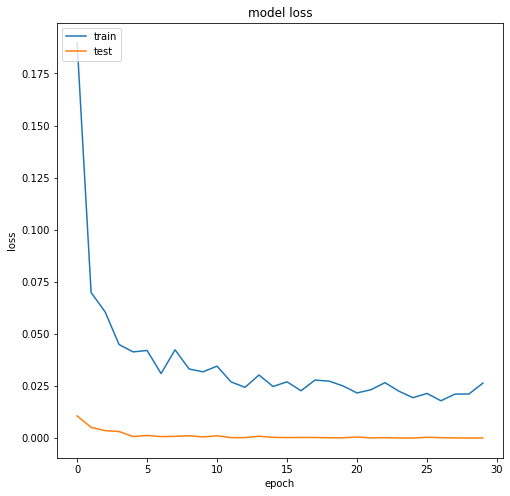

In [159]:
# summarize for Loss
fig_acc = plt.figure(figsize=(8,8))
plt.plot(single_step_history.history['loss'])
plt.plot(single_step_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

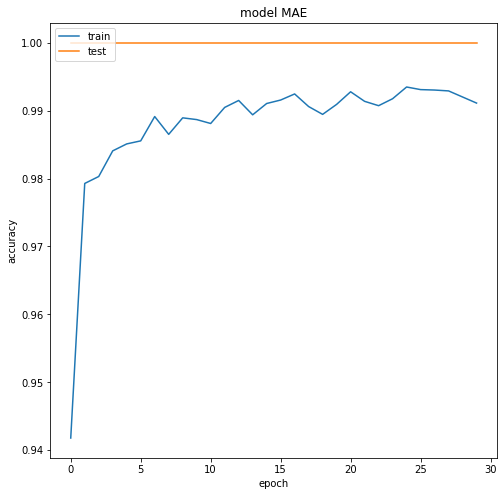

In [160]:
fig_acc = plt.figure(figsize=(8,8))
plt.plot(single_step_history.history['accuracy'])
plt.plot(single_step_history.history['val_accuracy'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [161]:
# Evaluation of training data
scores = model_cnn.evaluate(seq_gen_train, train_label_array, verbose=1)
print('logloss: {}'.format(scores[0])) 

489/489 [==============================] - 1s 2ms/step - loss: 0.0204 - accuracy: 0.9896
logloss: 0.02041487954556942


In [162]:
# Evaluation of cross val data
scores = model_cnn.evaluate(seq_array_cross, cross_label_array, verbose=1)
print('logloss: {}'.format(scores[0])) 

129/129 [==============================] - 0s 2ms/step - loss: 5.1820e-05 - accuracy: 1.0000
logloss: 5.181973028811626e-05


In [163]:
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('logloss: {}'.format(scores_test[0])) 

3/3 - 0s - loss: 0.0017 - accuracy: 1.0000
logloss: 0.0016519466880708933


#### Confusion matrix

In [164]:
y_pred_test = np.argmax(model_cnn.predict(seq_array_test_last), axis=-1)
y_true_test = label_array_test_last 

-------------------- Confusion matrix --------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


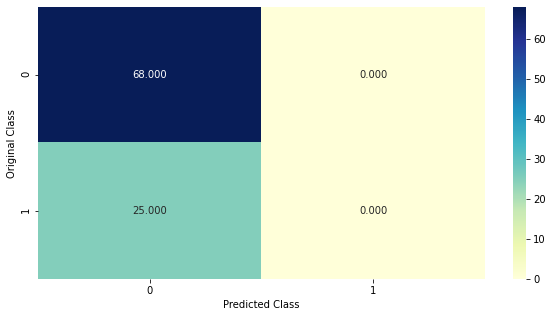

-------------------- Precision matrix (Columm Sum=1) --------------------


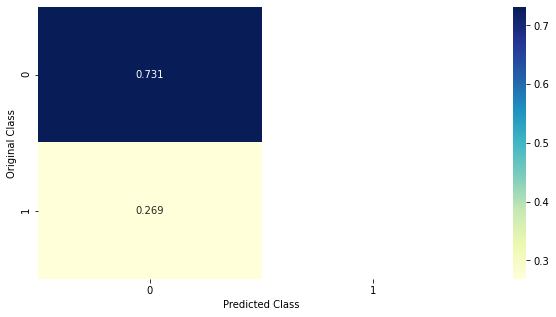

-------------------- Recall matrix (Row sum=1) --------------------


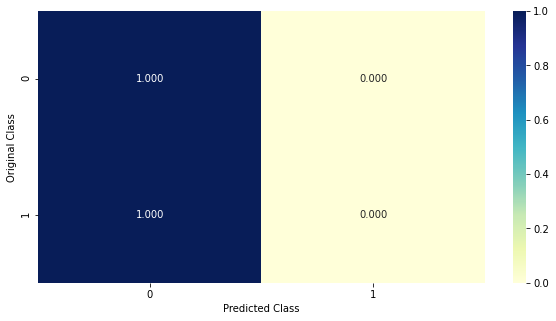

In [165]:
plot_confusion_matrix(y_true_test, y_pred_test)  

### LSTM Network

In [166]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(input_shape=seq_gen_train.shape[1:],units=32,return_sequences=False))
model_LSTM.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_LSTM.add(Dense(16, activation='relu'))
model_LSTM.add(BatchNormalization())
model_cnn.add(Dropout(0.2))
model_LSTM.add(Dense(units=1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                7424      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 8,161
Trainable params: 8,065
Non-trainable params: 96
_________________________________________________________________


In [167]:
checkpoint_callback = ModelCheckpoint('model_feaegg_LSTM_cla.h5', monitor='binary_crossentropy', save_best_only=True, mode='min', verbose=0)
# fit the network.
history = model_LSTM.fit(seq_gen_train,train_label_array, epochs=30, batch_size=32, callbacks=[checkpoint_callback],validation_data=(seq_array_cross, cross_label_array),shuffle=True, verbose=2) 

Epoch 1/30
489/489 - 3s - loss: 0.1244 - accuracy: 0.9629 - val_loss: 0.0358 - val_accuracy: 1.0000
Epoch 2/30
489/489 - 3s - loss: 0.0361 - accuracy: 0.9876 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 3/30
489/489 - 3s - loss: 0.0260 - accuracy: 0.9907 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/30
489/489 - 3s - loss: 0.0219 - accuracy: 0.9923 - val_loss: 4.9035e-04 - val_accuracy: 1.0000
Epoch 5/30
489/489 - 3s - loss: 0.0182 - accuracy: 0.9937 - val_loss: 6.3995e-04 - val_accuracy: 1.0000
Epoch 6/30
489/489 - 3s - loss: 0.0179 - accuracy: 0.9925 - val_loss: 4.9786e-04 - val_accuracy: 1.0000
Epoch 7/30
489/489 - 3s - loss: 0.0144 - accuracy: 0.9940 - val_loss: 2.4574e-04 - val_accuracy: 1.0000
Epoch 8/30
489/489 - 3s - loss: 0.0154 - accuracy: 0.9950 - val_loss: 5.2287e-04 - val_accuracy: 1.0000
Epoch 9/30
489/489 - 3s - loss: 0.0128 - accuracy: 0.9943 - val_loss: 2.1827e-04 - val_accuracy: 1.0000
Epoch 10/30
489/489 - 3s - loss: 0.0143 - accuracy: 0.9938 - val_loss: 1.641

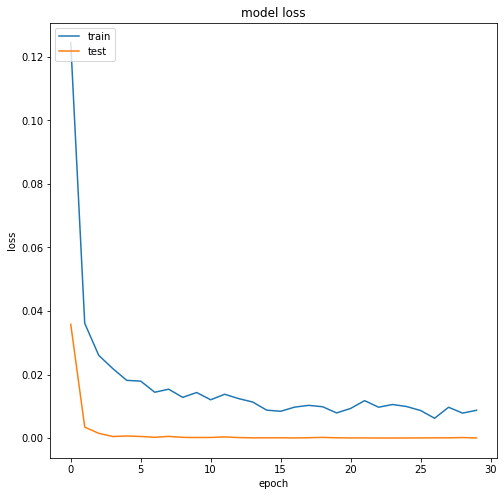

In [168]:
# summarize for Loss
fig_acc = plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

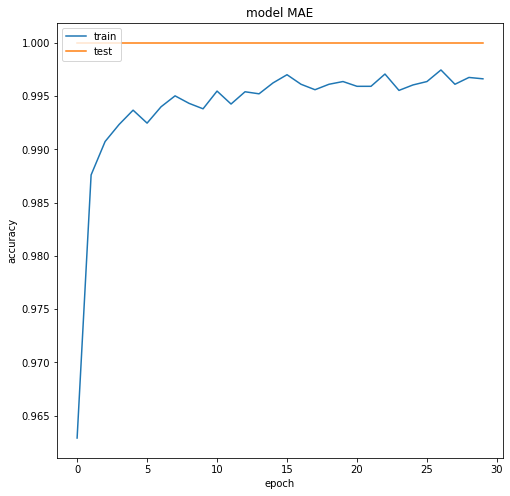

In [169]:
fig_acc = plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model MAE')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [170]:
# Evaluation of training data
scores = model_LSTM.evaluate(seq_gen_train, train_label_array, verbose=1, batch_size=32)
print('logloss: {}'.format(scores[1])) 

489/489 [==============================] - 1s 3ms/step - loss: 0.0057 - accuracy: 0.9962
logloss: 0.9962254762649536


In [171]:
# Evaluation of cross val data
scores = model_LSTM.evaluate(seq_array_cross, cross_label_array, verbose=1, batch_size=32)
print('logloss: {}'.format(scores[1]))

129/129 [==============================] - 0s 3ms/step - loss: 3.0430e-05 - accuracy: 1.0000
logloss: 1.0


In [172]:
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('logloss: {}'.format(scores_test[1]))

3/3 - 0s - loss: 2.8450e-04 - accuracy: 1.0000
logloss: 1.0


#### Confusion matrix

In [173]:
y_pred_test = np.argmax(model_LSTM.predict(seq_array_test_last), axis=-1)
y_true_test = label_array_test_last

-------------------- Confusion matrix --------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


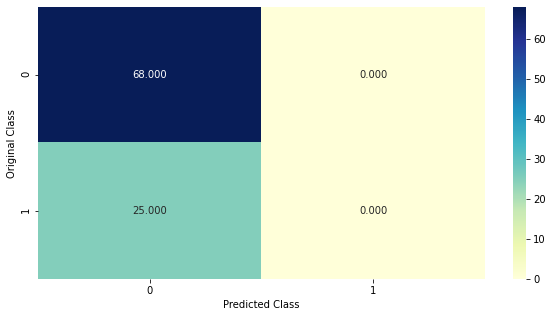

-------------------- Precision matrix (Columm Sum=1) --------------------


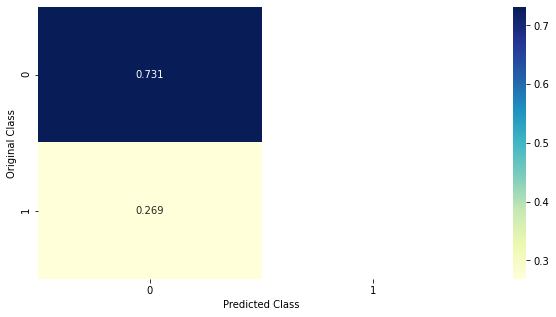

-------------------- Recall matrix (Row sum=1) --------------------


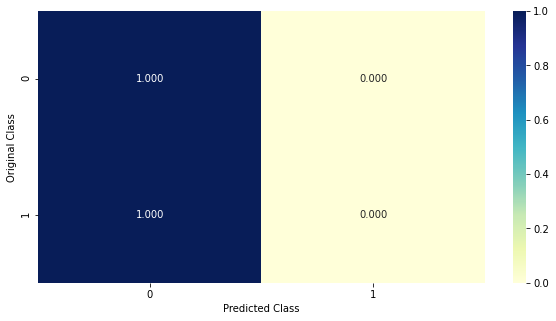

In [174]:
plot_confusion_matrix(y_true_test, y_pred_test)  

## Results

### Machine learning models

#### logistic regression

In [191]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD001/logistic_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15)) 

The test log loss is: 0.2056662734754976


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD002/logistic_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15)) 

The test log loss is: 0.12105662792102949


In [98]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD003/logistic_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.1292249081575084


In [220]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD004/logistic_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.19344683265525134


#### Liner_SVM

In [192]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD001/linear_svm_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.2056662734754976


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD002/linear_svm_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.12387146580880525


In [99]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD003/linear_svm_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.1292249081575084


In [221]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD004/linear_svm_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.19344683265525134


#### RF

In [194]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD001/RF_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.24021544746469722


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD002/RF_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.10119181727482067


In [100]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD003/RF_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.14855826880430745


In [222]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD004/RF_model_cali.pkl', 'rb')) 
predict_y = loaded_model.predict_proba(x_test) 
print( "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

The test log loss is: 0.17794967565283137


## Prettytable

In [223]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable() 
x.field_names = ["Model","FD001","FD002", "FD003", "FD004"] 
x.add_row(['logistic regression',"0.2056662734754976","0.12105662792102949","0.1292249081575084",'0.19344683265525134'])  
x.add_row(['Liner_SVM','0.2056662734754976','0.12387146580880525','0.1292249081575084','0.19344683265525134']) 
x.add_row(['Random forest regressor','0.24021544746469722','0.10119181727482067','0.14855826880430745','0.17794967565283137'])
print(x) 

+-------------------------+---------------------+---------------------+---------------------+---------------------+
|          Model          |        FD001        |        FD002        |        FD003        |        FD004        |
+-------------------------+---------------------+---------------------+---------------------+---------------------+
|   logistic regression   |  0.2056662734754976 | 0.12105662792102949 |  0.1292249081575084 | 0.19344683265525134 |
|        Liner_SVM        |  0.2056662734754976 | 0.12387146580880525 |  0.1292249081575084 | 0.19344683265525134 |
| Random forest regressor | 0.24021544746469722 | 0.10119181727482067 | 0.14855826880430745 | 0.17794967565283137 |
+-------------------------+---------------------+---------------------+---------------------+---------------------+


- For data set FD001 and FD003, logistic regression and liner_SVM are work fine at sea level operating conditions.

- Random forest regressor working fine when operating conditions are various(six) for data sets FD002 and FD004